In [1]:
import matplotlib.pyplot as plt
import numpy as np

[7]


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

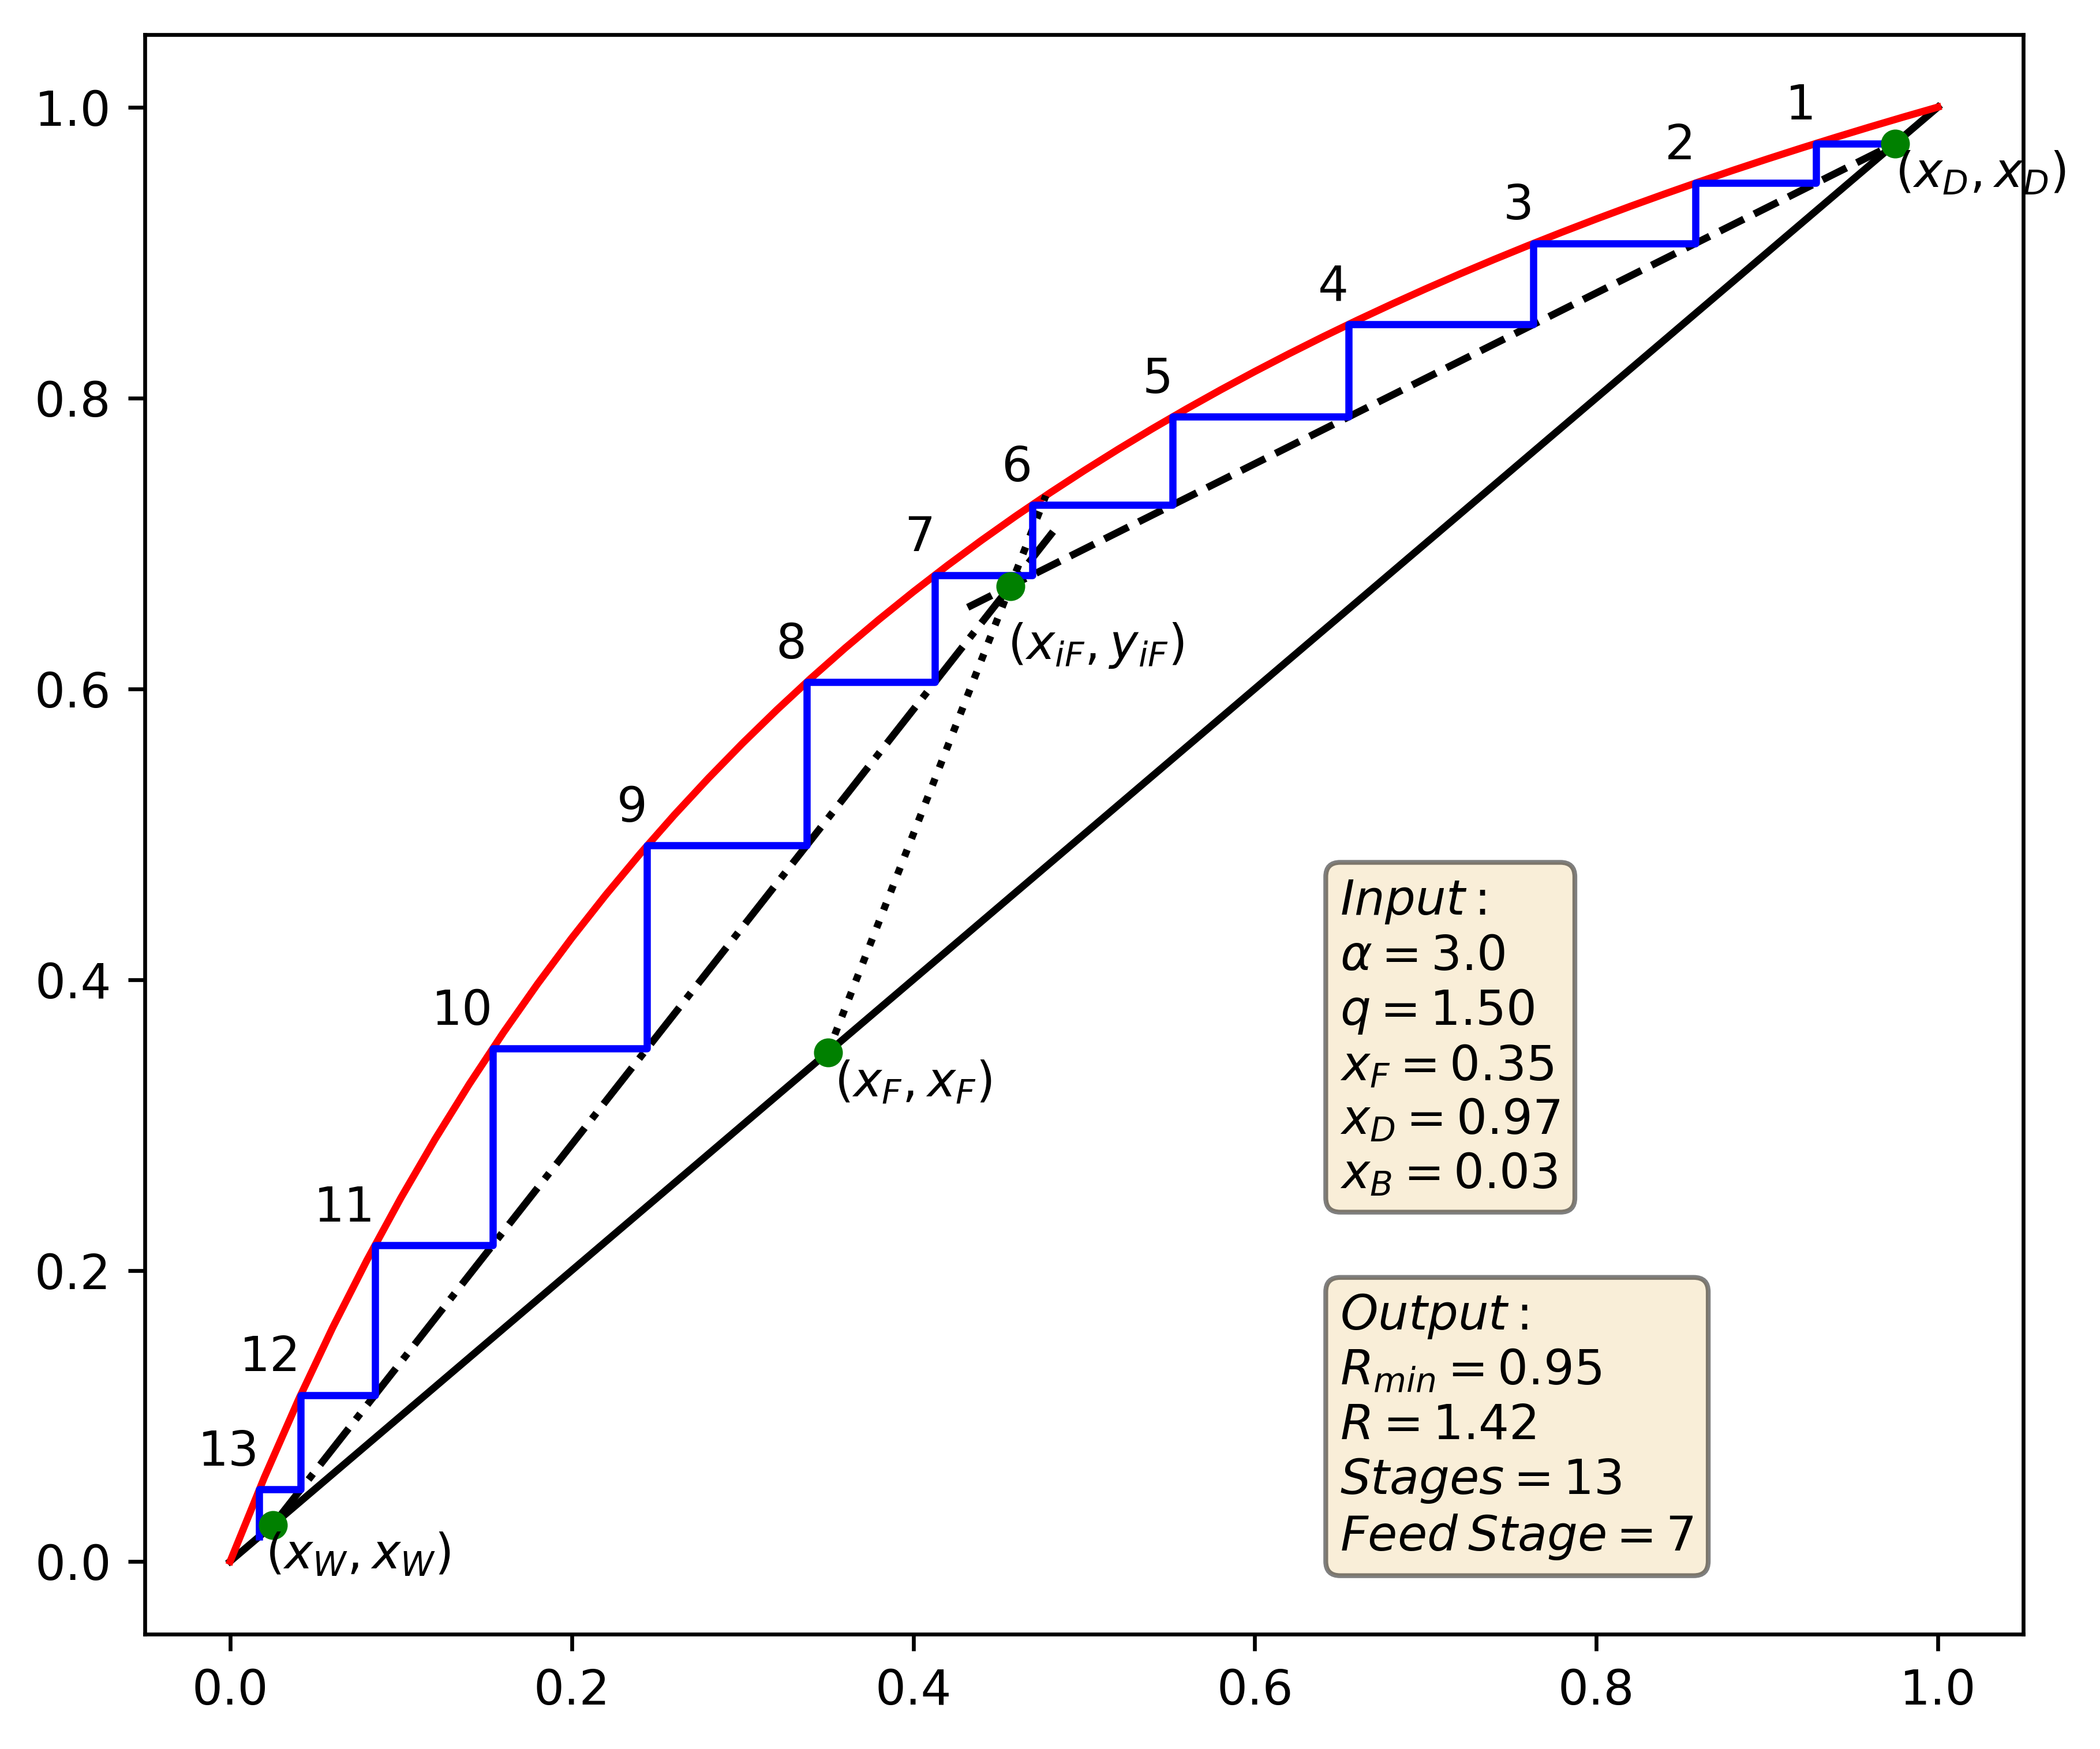

In [5]:
xF = 0.35        # Light component mole fraction in feed, -
xD = 0.975       # Light component mole fraction in distillate, -
xW = 0.025       # Light component mole fraction in reboiler, -
R = 1.5          # Reflux ratio (L/D), -
a = 3.0          # Separation factor
q = 1.5          # Feed condition


######## Equilibrium curve ########
def eq_curve(a):
    x_eq = np.linspace(0,1,51)
    y_eq = a*x_eq/(1+(a-1)*x_eq)
    return y_eq, x_eq
y_eq, x_eq = eq_curve(a)


######## Feed line ########
def fed(xF,q,a):    
    c1 = (q*(a-1))
    c2 = q + xF*(1-a) - a*(q-1)
    c3 = -xF
    coeff = [c1, c2, c3]
    r = np.sort(np.roots(coeff))
    
    if r[0]>0:
        xiE = r[0]
    else:
        xiE = r[1]
   
    yiE = a*xiE/(1+ xiE*(a-1))
    if q == 1:
        x_fed = [xF, xF]
        y_fed = [xF, yiE]
    else:
        x_fed = np.linspace(xF, xiE, 51)
        y_fed = q/(q-1)*x_fed - xF/(q-1)
    
    return xiE, yiE, y_fed, x_fed
xiE, yiE, y_fed, x_fed = fed(xF,q,a)


######## R_min & R (new) ########
R_min = (xD-yiE)/(yiE-xiE)
R = R*R_min


######## Feed Point ########
xiF = (xF/(q-1)+xD/(R+1))/(q/(q-1)-R/(R+1))
yiF = R/(R+1)*xiF + xD/(R+1)
######## Rectifying section ########
def rect(R,xD,xiF):
    x_rect = np.linspace(xiF-0.025,xD,51)    
    y_rect = R/(R+1)*x_rect + xD/(R+1)
    return y_rect,x_rect
y_rect, x_rect = rect(R, xD,xiF)
######## Stripping section ########
def stp(xiF,yiF,xW):
    x_stp = np.linspace(xW,xiF+0.025,51)    
    y_stp = ((yiF-xW)/(xiF-xW))*(x_stp-xW) + xW
    return y_stp,x_stp
y_stp, x_stp = stp(xiF,yiF,xW)



######## Stage Construction ########
s = np.zeros((1000,5)) # Empty array (s) to calculate coordinates of stages
for i in range(1,1000):
    # (s[i,0],s[i,1]) = (x1,y1) --> First point
    # (s[i,2],s[i,3]) = (x2,y2) --> Second point
    # Joining (x1,y1) and (x2,y2) will result into stages
    
    s[0,0] = xD
    s[0,1] = xD
    s[0,2] = s[0,1]/(a-s[0,1]*(a-1))
    s[0,3] = s[0,1]
    s[0,4] = 0
# x1
    s[i,0] = s[i-1,2]
    
    # Breaking step once (x1,y1) < (xW,xW)
    if s[i,0] < xW:
        s[i,1] = s[i,0] 
        s[i,2] = s[i,0]
        s[i,3] = s[i,0]
        s[i,4] = i
        break  
    
    # y1
    if s[i,0] > xiF:
        s[i,1] = R/(R+1)*s[i,0] + xD/(R+1)
    elif s[i,0] < xiF:
        s[i,1] = ((yiF-xW)/(xiF-xW))*(s[i,0]-xW) + xW
    else:
        s[i,1] = s[i-1,3]
    
    # x2
    if s[i,0] > xW:
        s[i,2] = s[i,1]/(a-s[i,1]*(a-1))
    else:
        s[i,2] = s[i,0]
    
    # y2
    s[i,3] = s[i,1]
    
    # No of stages
    if s[i,0] < xiF:
        s[i,4] = i
    else:
        s[i,4] = 0
s = s[~np.all(s == 0, axis=1)] # Clearing up zero containing rows
s_rows = np.size(s,0)  
#print(s)
S = np.zeros((s_rows*2,2)) # Empty array to rearragne 's' array for plotting
for i in range(0,s_rows):
    S[i*2,0] = s[i,0]
    S[i*2,1] = s[i,1]
    S[i*2+1,0] = s[i,2]
    S[i*2+1,1] = s[i,3]
######## Stage Numbering ########
# (x2,y2) from 's' array as (x_s,y_s) used for stage numbering
x_s = s[:,2:3]
y_s = s[:,3:4]
stage = np.char.mod('%d', np.linspace(1,s_rows-1,s_rows-1))


s_f = s_rows-np.count_nonzero(s[:,4:5], axis=0)
print(s_f)


fig = plt.figure(num=None, figsize=(7, 6), dpi=600)
# Parity line
plt.plot([0,1],[0,1],"k-")
# Equilibrium curve
plt.plot(x_eq,y_eq,"r-", label="Equilibrium Curve")
# Rectifying section line
plt.plot(x_rect,y_rect,'k--', label="Rectifying Section OL") 
# Stripping section line
plt.plot(x_stp,y_stp,'k-.', label="Stripping Section OL")
# Feed line
plt.plot(x_fed,y_fed,'k:', label="Feed OL")
# Stages
plt.plot(S[:,0],S[:,1],'b-', label="Stages")
# Stage numbers
for label, x, y in zip(stage, x_s, y_s):
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(0,5),
                 textcoords='offset points', 
                 ha='right')
# Feed, Distillate and Reboiler points
plt.plot(xF,xF,'go',xD,xD,'go',xW,xW,'go',markersize=5)   
plt.text(xF+0.05,xF-0.03,'($x_{F}, x_{F}$)',horizontalalignment='center')
plt.text(xD+0.05,xD-0.03,'($x_{D}, x_{D}$)',horizontalalignment='center')
plt.text(xW+0.05,xW-0.03,'($x_{W}, x_{W}$)',horizontalalignment='center')
# Intersection: Rectifying + Stripping + Feedline
plt.plot(xiF,yiF,'go',markersize=5)
plt.text(xiF+0.05,yiF-0.05,'($x_{iF}, y_{iF}$)',horizontalalignment='center')
# Creating a nice output boxes
textstr1 = '\n'.join((
    r'$Input:$',
    r'$\alpha=%.1f$' % (a, ),
    r'$q=%.2f$' % (q, ),
    r'$x_F=%.2f$' % (xF, ),
    r'$x_D=%.2f$' % (xD, ),
    r'$x_B=%.2f$' % (xW, )))
textstr2 = '\n'.join((
    r'$Output:$',
    r'$R_{min}=%.2f$' % (R_min, ),
    r'$R=%.2f$' % (R, ),
    r'$Stages=%.0f$' % (s_rows-1, ),
    r'$Feed \:Stage=%.0f$' % (s_f, )))
# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.65, 0.25, textstr1, fontsize=10, verticalalignment='bottom', bbox=props)
plt.text(0.65, 0.0, textstr2, fontsize=10, verticalalignment='bottom', bbox=props)
# General plot settings
plt.grid(b=True, which='major',linestyle=':',alpha=0.6)
plt.grid(b=True, which='minor',linestyle=':',alpha=0.3)
plt.minorticks_on()
plt.legend(loc="upper left")
plt.xlabel("x (-)")
plt.ylabel("y (-)")
plt.savefig('McCabe - Thiele Method.jpeg', dpi=fig.dpi)
plt.title("Binary Distillation : McCabe - Thiele Method")
plt.show()